# Implementación de ResNet

En este ejercicio práctico vamos a implementar una red neuronal con conexiones residuales y vamos a probar como dichas conexiones evitan que la performance se degrade al aumentar las capas de la red neuronal. Además vamos a utilizar el metodo "funcional" de programación que tiene Keras, el cual se podria considerar de mas bajo nivel y, por lo tanto, nos permite tener más control sobre las conexiones internas de la red neuronal.

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math

Para este caso vamos a entrenar a las redes neuronales para que aproximen la función seno, por lo que vamos a generar datos utilizando dicha función. Además, el dataset lo vamos a manejar con el módulo [`data`](https://www.tensorflow.org/api_docs/python/tf/data?hl=es-419) de Tensorflow.

In [ ]:
def sin():

  while True:
    x = tf.random.normal(shape=(32, 10), mean=math.pi, stddev=1.5)
    y = tf.math.sin(x)
    yield (x, y)

dataset = tf.data.Dataset.from_generator(generator=sin, output_types=(tf.float32, tf.float32), output_shapes=((32, 10), (32, 10)))

## ResNet vs Red "plana"

Con el objetivo de probar el funcionamiento de las conexiones residuales, generamos modelos "planos", es decir, sin dichas conexiones y los entrenamos aumentando cada vez mas la cantidad de capas densas en los mismos. Luego, repetimos el proceso para modelos de iguales cantidades de capas pero agregando las conexiones residuales. Finalmente comparamos la evolución del error al final del entrenamiento, a medida que se van incrementando la cantidad de capas, para ambos casos.


In [ ]:
# Defino la cantidad de capas que quiero que tenga la red mas grande
layers_amount = 25

### Entrenamiento red "plana"

In [ ]:
def build_plain_model(layers):

  input = tf.keras.Input(shape=(10,))
  x = tf.keras.layers.Dense(units=10, activation="relu")(input)
  
  for _ in range(layers - 2):

    x = tf.keras.layers.Dense(units=10, activation="relu")(x)
  
  # Agrego ultima capa densa sin funcion de activacion
  output = tf.keras.layers.Dense(10)(x)
  
  model = tf.keras.Model(input, output)
  model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.MeanSquaredError())
  
  return model

In [ ]:
print("Entrenamiento redes neuronales planas")

plain_loss_history = []

for layers in range(1, layers_amount):
    
    plain_model = build_plain_model(layers)
    plain_model.summary()
    hist = plain_model.fit(dataset, steps_per_epoch=20, epochs=20*layers, verbose=0)
    plain_loss_history.append(hist.history["loss"][-1])
    del plain_model

Entrenamiento redes neuronales planas


### Entrenamiento de ResNet

In [ ]:
# Funcion que crea un bloque residual
def resblock(input):

  x = tf.keras.layers.Dense(units=10, activation="relu")(input)
  x = tf.keras.layers.Dense(units=10)(x)
  x = x + input
  x = tf.keras.layers.Activation("relu")(x)
  
  return x


def build_resnet_model(layers):

  input = tf.keras.Input(shape=(10,))
  x = tf.keras.layers.Dense(units=10, activation='relu')(input)

  # cada bloque residual tiene dos capas
  for _ in range((layers - 2)//2):
      
      x = resblock(x)

  output = tf.keras.layers.Dense(units=10)(x)

  model = tf.keras.Model(input, output)
  model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.MeanSquaredError())
  
  return model

In [ ]:
print("Entrenamiento redes neuronales residuales")

resnet_loss_history = []

for layers in range(1, layers_amount):
    
    resnet = build_resnet_model(layers)
    hist = resnet.fit(dataset, steps_per_epoch=20, epochs=20*layers, verbose=0)
    resnet_loss_history.append(hist.history["loss"][-1])

Entrenamiento redes neuronales residuales


## Grafica con los resultados

En la siguiente grafica se puede observar como evoluciona el error de entrenamiento a medida que se incrementa la cantidad de capas dentro de la red.

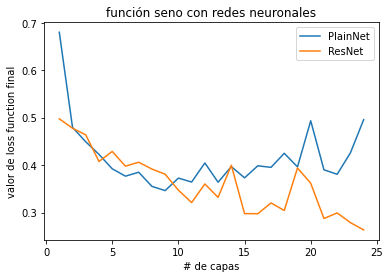

In [ ]:
plt.plot(range(1, layers_amount), plain_loss_history, label="PlainNet")
plt.plot(range(1, layers_amount), resnet_loss_history, label="ResNet")
plt.title("función seno con redes neuronales")
plt.xlabel("# de capas")
plt.ylabel("valor de loss function final")
plt.legend()
plt.show()